## About DistilBERT

**DistilBERT** is a compressed version of **BERT-base** designed to be smaller, faster, and lighter:  

| Property | DistilBERT | BERT-base |
|----------|------------|-----------|
| Hidden layers | 6 | 12 |
| Hidden size | 768 | 768 |
| Attention heads | 12 | 12 |
| Parameters | ~66M | ~110M |
| Vocabulary size | 30,000 | 30,000 |
| Training method | Knowledge Distillation from BERT | Standard pretraining on masked LM & next sentence prediction |
| Speed | ~60% faster | Baseline |
| Size | ~40% smaller | Baseline |

**Key points:**  
- Trained using **knowledge distillation**, learning from BERT-base (teacher model).  
- Retains ~97% of BERT-base performance on GLUE benchmark.  
- Ideal for fine-tuning on **text classification**, **NER**, or other NLP tasks with limited compute.  

> In this notebook, we fine-tune **DistilBERT** on the **Sentiment140** dataset for binary sentiment classification.


#### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from transformers import (
AutoTokenizer,AutoModelForSequenceClassification,TrainingArguments,Trainer
)
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#### Data ingestion and Preprocessing

In [ ]:
# Ingesting the data
df_tweet=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')

# Resetting the column name
df_tweet.iloc[-1]=df_tweet.columns
df_tweet=df_tweet.sort_index().reset_index(drop=True)

In [4]:
df_tweet.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
# Renaming the columns
df_tweet.columns=['target','id','date','query_status','username','tweet']

# Selecting only required columns for LLM
df_tweet=df_tweet[['id','tweet','target']]

In [6]:
df_tweet.head()

,id,tweet,target
0,1467810672,is upset that he can't update his Facebook by ...,0
1,1467810917,@Kenichan I dived many times for the ball. Man...,0
2,1467811184,my whole body feels itchy and like its on fire,0
3,1467811193,"@nationwideclass no, it's not behaving at all....",0
4,1467811372,@Kwesidei not the whole crew,0


In [7]:
df_tweet['target'].unique()

array([0, 4, '0'], dtype=object)

In [8]:
# Convert entire target column to int
df_tweet['target']=df_tweet['target'].astype(str).astype(int)

# Maping lables: 0(Negative)->0,4(Positive)->1
df_tweet['target']=df_tweet['target'].replace({
                                              0:0,
                                                4:1})

In [9]:
print(df_tweet['target'].unique())

[0 1]


In [10]:
# Taking 200k Tweets for training the model
df_0=df_tweet.loc[df_tweet['target']==0].head(100000)
df_1=df_tweet.loc[df_tweet['target']==1].head(100000)

df_tweet=pd.concat([df_1,df_0]).sample(frac=1,random_state=42)

In [11]:
df_tweet.target.value_counts()

target
0    100000
1    100000
Name: count, dtype: int64

In [12]:
df_tweet.head()

,id,tweet,target
19737,1556921271,@CirculatingLib Sorry you've had such a crap d...,0
872271,1678973912,I shall wake up earlier tmr to continue work. ...,1
58154,1685832754,needs to get a few hours of sleep before she h...,0
865425,1677459360,@missgiggly hazzah - me too,1
830073,1557256819,@Dannymcfly http://twitpic.com/3iqyf - hot la...,1


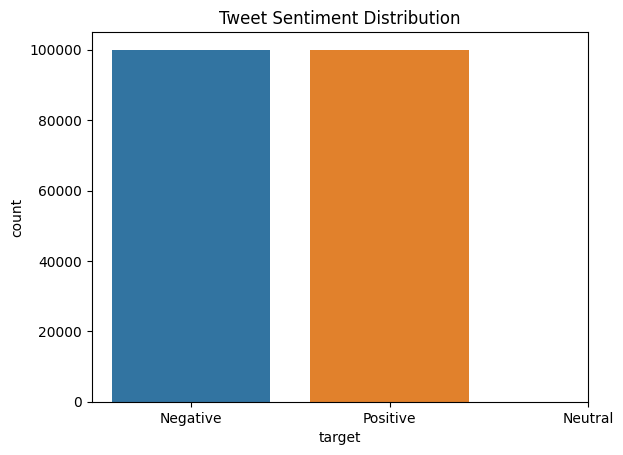

In [13]:
import seaborn as sns

# Class Distribution
sns.countplot(x='target', data=df_tweet)
plt.xticks([0,1,2], ['Negative','Positive','Neutral'])
plt.title('Tweet Sentiment Distribution')
plt.show()

In [14]:
# Initialize StratifiedShuffleSplit with 1 split, 70% train, 30% validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

# Split the dataset while preserving the label distribution
for train_index, val_index in sss.split(df_tweet['tweet'], df_tweet['target']):
    # Convert the pandas series to lists for tokenization
    train_texts = df_tweet["tweet"].iloc[train_index].tolist()
    val_texts   = df_tweet["tweet"].iloc[val_index].tolist()
    train_labels = df_tweet["target"].iloc[train_index].tolist()
    val_labels   = df_tweet["target"].iloc[val_index].tolist()

print(len(train_texts))
print(len(val_texts))

140000
60000


### Training LLM-distilbert

In [15]:
# Initialize tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizing the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Inspect a single example
print(train_encodings['input_ids'][0])
print(train_encodings['attention_mask'][0])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[101, 27984, 2232, 2019, 4540, 8985, 1998, 2358, 2890, 2361, 3759, 1012, 1012, 2821, 1996, 6569, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
from datasets import Dataset

# Training dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

# Validation dataset
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})


In [17]:
# Load the pre-trained model
model=AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [22]:
from sklearn.metrics import f1_score, accuracy_score
# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1}


In [23]:
# Early Stopping
from transformers import EarlyStoppingCallback

callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

In [24]:
# Training arguments
training_args = TrainingArguments(
    output_dir='kaggle/working/distilbert-tweet',
    run_name='sentiment_classification',
    eval_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to='none',
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=callbacks
)

In [25]:
# Training the Model
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.190400,0.385624,0.838600,0.838568
2,0.199500,0.427372,0.841233,0.841209
3,0.109800,0.563471,0.839267,0.839267


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=6564, training_loss=0.1728663319570854, metrics={'train_runtime': 2688.532, 'train_samples_per_second': 156.219, 'train_steps_per_second': 2.441, 'total_flos': 1.282243022928e+16, 'train_loss': 0.1728663319570854, 'epoch': 3.0})

#### Save the model

In [ ]:
trainer.save_model("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

### Evaluating the model

In [ ]:
# Make predictions on the validation set
predictions = trainer.predict(val_dataset)

# Get the predicted labels (by taking the argmax of the logits)
predicted_labels = predictions.predictions.argmax(axis=-1)

In [27]:
# Calculating the accuracy
accuracy = accuracy_score(val_labels, predicted_labels)
print(f"Accuracy: {accuracy*100:.2f} %")

# Generating detailed classification report
report = classification_report(val_labels, predicted_labels, target_names=["Negative", "Positive"])
print(report)

Accuracy: 83.86 %
              precision    recall  f1-score   support

    Negative       0.83      0.85      0.84     30000
    Positive       0.85      0.82      0.84     30000

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000



### Outcome
- **Model:** DistilBERT (`distilbert-base-uncased`)  
- **Dataset:** Sentiment140 (60k eval samples, 200k train subset)  
- **Training Loss:** 0.173  
- **Accuracy:** 83.86%  
- **F1-score:** 0.84  
- **Class-wise:**  
  - Negative → Precision: 0.83, Recall: 0.85, F1: 0.84  
  - Positive → Precision: 0.85, Recall: 0.82, F1: 0.84  

### Notes / Observations
- Achieved ~84% accuracy after 3 epochs.  
- Training on GPU: ~156 samples/sec.  
- Dataset balanced for positive/negative.  
- Further tuning or more epochs could improve performance.  

### References / Resources
- [Hugging Face Transformers](https://huggingface.co/transformers)  
- [Sentiment140 Dataset](https://www.kaggle.com/datasets/kazanova/sentiment140)
